In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import duckdb
import pandas as pd

## Statistics of unfiltered data:
- [x] Conversation length 
- [x] Authors per conversation
- [x] Archived posts
- [x] Controversial posts
- [ ] Swear words

In [4]:
posts = pl.scan_csv("posts.csv")

In [5]:
df_counts = posts.collect()["archived"].value_counts()

df_percentages = df_counts.with_columns(
    (pl.col("count") / pl.col("count").sum() * 100).alias("percent")
)

print(df_percentages)

shape: (2, 3)
┌──────────┬──────────┬───────────┐
│ archived ┆ count    ┆ percent   │
│ ---      ┆ ---      ┆ ---       │
│ bool     ┆ u32      ┆ f64       │
╞══════════╪══════════╪═══════════╡
│ false    ┆ 20485    ┆ 0.072392  │
│ true     ┆ 28276700 ┆ 99.927608 │
└──────────┴──────────┴───────────┘


In [6]:
df_counts = posts.collect()["subreddit"].value_counts()

df_sorted = df_counts.sort("count", descending=True)

df_percentages = df_sorted.with_columns(
    (pl.col("count") / pl.col("count").sum() * 100).alias("percent")
)

print(df_percentages)

shape: (511_956, 3)
┌──────────────────┬────────┬──────────┐
│ subreddit        ┆ count  ┆ percent  │
│ ---              ┆ ---    ┆ ---      │
│ str              ┆ u32    ┆ f64      │
╞══════════════════╪════════╪══════════╡
│ AskReddit        ┆ 517870 ┆ 1.830111 │
│ memes            ┆ 359834 ┆ 1.271625 │
│ u_toronto_news   ┆ 244017 ┆ 0.862337 │
│ dirtykikpals     ┆ 185725 ┆ 0.656337 │
│ teenagers        ┆ 176409 ┆ 0.623415 │
│ …                ┆ …      ┆ …        │
│ u_hiimUGithink   ┆ 1      ┆ 0.000004 │
│ u_Rizki_Fox      ┆ 1      ┆ 0.000004 │
│ u_Minoa974       ┆ 1      ┆ 0.000004 │
│ ClickBaitGarbage ┆ 1      ┆ 0.000004 │
│ u_yenpoy         ┆ 1      ┆ 0.000004 │
└──────────────────┴────────┴──────────┘


In [7]:
comments = pl.scan_csv("comments.csv")

In [8]:
con = duckdb.connect()

query = """
WITH counts AS (
    SELECT controversiality,
           COUNT(*) AS count
    FROM read_csv_auto(
            'comments.csv',
            null_padding=True,
            ignore_errors=True
         )
    GROUP BY controversiality
)
SELECT controversiality,
       count,
       ROUND(count * 100.0 / SUM(count) OVER (), 4) AS percent
FROM counts
WHERE controversiality IN (0.0, 1.0)
ORDER BY controversiality;
"""

df_percentages = con.execute(query).fetchdf()
print(df_percentages)

   controversiality      count  percent
0                 0  184798753  98.1708
1                 1    3443391   1.8292


In [9]:
df_controversiality_one = con.execute(
    """
    SELECT body
    FROM read_csv_auto(
            'comments.csv',
            null_padding=True,
            ignore_errors=True
         )
    WHERE controversiality = 1
"""
).fetchdf()

In [10]:
df_controversiality_one.value_counts()

body                                                                                                                                                          
[deleted]                                                                                                                                                         226546
[removed]                                                                                                                                                          98456
Nice                                                                                                                                                                2614
No                                                                                                                                                                  2047
F                                                                                                                                                                   1

In [11]:
def plot_parent_id_frequency(filepath: str, max_display: int = 10) -> None:
    """
    Create a bar plot showing how often parent_ids occur in the dataset.

    Args:
        filepath (str): Path to the data file (CSV)
        max_display (int): Number of initial frequencies to display separately
    """
    # Create lazy frame and compute frequency distribution
    frequency_df = (
        pl.scan_csv(filepath)
        .group_by("parent_id")
        .agg(pl.len().alias("frequency"))
        .group_by("frequency")
        .agg(pl.len().alias("count"))
        .sort("frequency")
        .collect()
    )

    # Convert to numpy arrays for plotting
    freqs = frequency_df["frequency"].to_numpy()
    counts = frequency_df["count"].to_numpy()

    # Split data for plotting
    display_mask = freqs <= max_display
    display_freqs = freqs[display_mask]
    display_counts = counts[display_mask]

    # Calculate tail statistics
    tail_sum = counts[~display_mask].sum() if len(freqs[~display_mask]) > 0 else 0

    # Prepare plot data
    plot_freqs = (
        list(display_freqs) + [f">{max_display}"]
        if tail_sum > 0
        else list(display_freqs)
    )
    plot_counts = (
        list(display_counts) + [tail_sum] if tail_sum > 0 else list(display_counts)
    )

    # Create the visualization
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars
    bars = ax.bar(range(len(plot_freqs)), plot_counts, color="skyblue")

    # Customize the plot
    plt.title("Distribution of Parent ID Frequencies", pad=20)
    plt.xlabel("Number of Replies per Parent")
    plt.ylabel("Number of Parents (log scale)")

    # Set log scale for y-axis
    ax.set_yscale("log")

    # Set x-ticks to actual frequency values
    plt.xticks(range(len(plot_freqs)), plot_freqs)

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height):,}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total unique parent IDs: {frequency_df['count'].sum():,}")
    print(
        f"Most common frequency: {frequency_df.filter(pl.col('count').max() == pl.col('count'))['frequency'][0]} replies"
    )

    if tail_sum > 0:
        tail_parents = (freqs[~display_mask] * counts[~display_mask]).sum()
        max_freq = freqs.max()
        print(f"\nTail Statistics (>{max_display} replies):")
        print(f"Parents with >{max_display} replies: {tail_sum:,}")
        print(f"Total replies in tail: {int(tail_parents):,}")
        print(f"Maximum replies to a single parent: {max_freq:,}")

    return frequency_df


Summary Statistics:
Total unique parent IDs: 91,721,856
Most common frequency: 1 replies

Tail Statistics (>20 replies):
Parents with >20 replies: 547,607
Total replies in tail: 36,962,830
Maximum replies to a single parent: 99,155


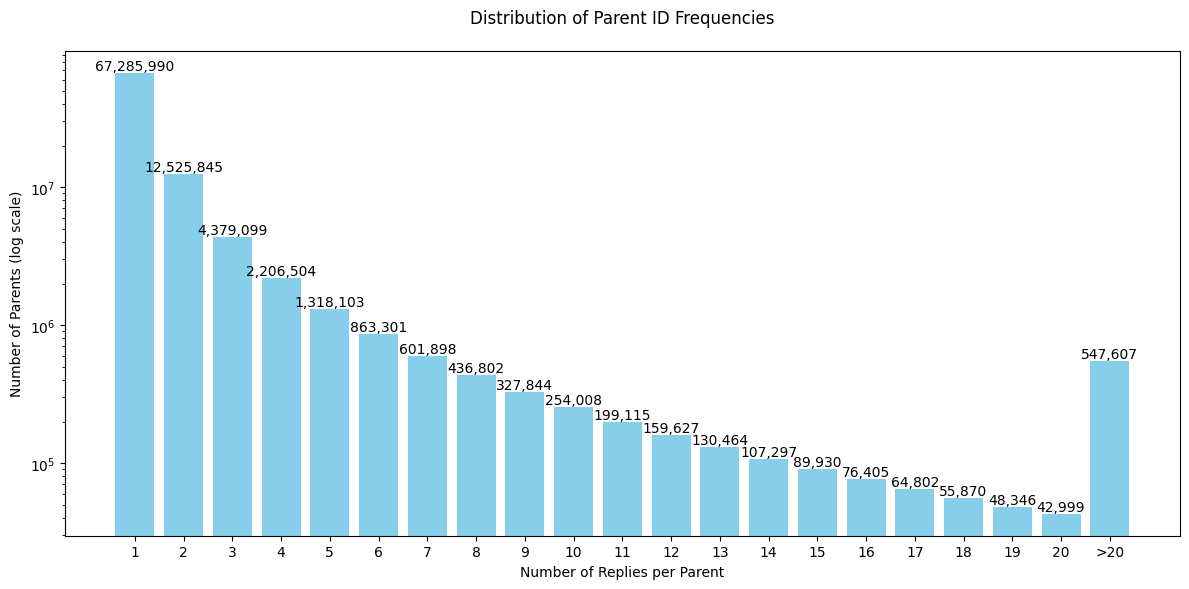

In [12]:
df = plot_parent_id_frequency("comments.csv", max_display=20)

In [13]:
df.head

<bound method DataFrame.head of shape: (2_344, 2)
┌───────────┬──────────┐
│ frequency ┆ count    │
│ ---       ┆ ---      │
│ u32       ┆ u32      │
╞═══════════╪══════════╡
│ 1         ┆ 67285990 │
│ 2         ┆ 12525845 │
│ 3         ┆ 4379099  │
│ 4         ┆ 2206504  │
│ 5         ┆ 1318103  │
│ …         ┆ …        │
│ 55956     ┆ 1        │
│ 65196     ┆ 1        │
│ 83273     ┆ 1        │
│ 99139     ┆ 1        │
│ 99155     ┆ 1        │
└───────────┴──────────┘>

In [14]:
mean_frequency = (df["frequency"] * df["count"]).sum() / df["count"].sum()

print(mean_frequency)

2.0714122814959173


In [15]:
df_sorted = df.sort("frequency")

cumsum_array = np.cumsum(df_sorted["count"].to_numpy())

df_sorted = df_sorted.with_columns(pl.Series("cumulative_count", cumsum_array))

total_count = df_sorted["count"].sum()

weighted_median = df_sorted.filter(pl.col("cumulative_count") >= total_count / 2)[
    "frequency"
].min()

print("Weighted median frequency:", weighted_median)
print(
    "Percentage of frequency 1:",
    f"{df_sorted.filter(pl.col("frequency") == 1)["count"].sum() / total_count * 100}%",
)
print(
    "Percentage of frequencies 4 to 10:",
    f" {(
        df_sorted.filter((pl.col("frequency") >= 4) & (pl.col("frequency") <= 10))[
            "count"
        ].sum()
        / total_count
    )
    * 100}%",
)

Weighted median frequency: 1
Percentage of frequency 1: 73.3587314238386%
Percentage of frequencies 4 to 10:  6.550739662311238%


In [16]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to DuckDB (in-memory by default)
con = duckdb.connect()

# DuckDB query to count distinct authors per id and group values
query = """
WITH author_counts AS (
    SELECT 
        parent_id, 
        COUNT(DISTINCT author) AS num_authors
    FROM read_csv_auto('comments.csv',
                       null_padding=True,
                       ignore_errors=True)
    GROUP BY parent_id
),
grouped AS (
    SELECT 
        CASE 
            WHEN num_authors >= 10 THEN '10+'
            ELSE CAST(num_authors AS VARCHAR)
        END AS author_group,
        COUNT(*) AS frequency
    FROM author_counts
    GROUP BY author_group
)
SELECT *
FROM grouped
ORDER BY 
    CASE 
        WHEN author_group = '10+' THEN 10
        ELSE CAST(author_group AS INTEGER)
    END;
"""

df_grouped = con.execute(query).fetchdf()
print(df_grouped)

  author_group  frequency
0            1   67982027
1            2   11833222
2            3    4185962
3            4    2117568
4            5    1259041
5            6     820063
6            7     568283
7            8     409849
8            9     306264
9          10+    1590469


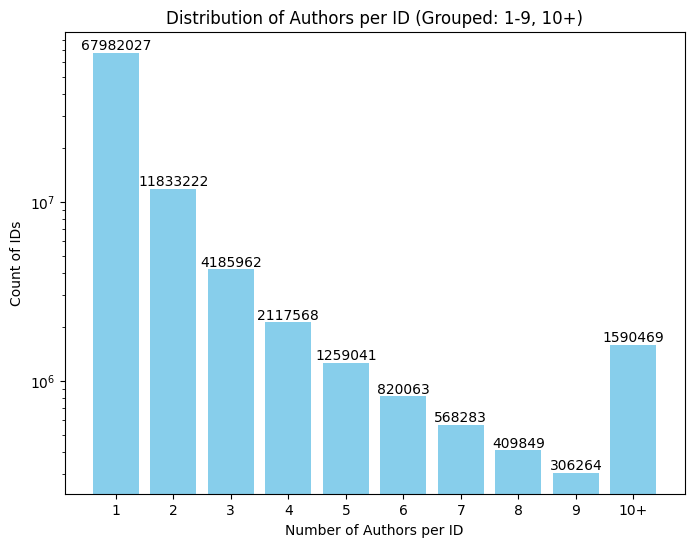

In [17]:
# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(df_grouped["author_group"], df_grouped["frequency"], color="skyblue")
plt.yscale("log")

plt.xlabel("Number of Authors per ID")
plt.ylabel("Count of IDs")
plt.title("Distribution of Authors per ID (Grouped: 1-9, 10+)")

# Add frequency value on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,  # y position: top of the bar
        f"{int(height)}",  # label (cast to int if desired)
        ha="center",
        va="bottom",  # center alignment
        fontsize=10,
    )

plt.show()

## Filtering Data:
- Aim for a few hundred to a thousand posts
- Try to find few but very high quality subreddits

### Criteria to compare to agent discussions:
- 3 authors with at least 2 turns each
- Less than 10% swear words to avoid unproductive discussions
- Score of at least _ ?

In [9]:
con = duckdb.connect()

query = """
SELECT 
    LEFT(name, 4) AS first_character,
    COUNT(*) AS count
FROM read_csv_auto('posts.csv',
    null_padding=True,
    ignore_errors=True)
WHERE id IS NOT NULL
GROUP BY first_character
ORDER BY count DESC;
"""

df_first_char = con.execute(query).fetchdf()
df_first_char.head(10)

,first_character,count
0,t3_g,27866492
1,None,435
2,1,80
3,and,44
4,but,43
5,the,32
6,0,20
7,2,17
8,,14
9,so,13


In [10]:
con = duckdb.connect()

query = """
SELECT 
    LEFT(id, 1) AS first_character,
    COUNT(*) AS count
FROM read_csv_auto('comments.csv',
    null_padding=True,
    ignore_errors=True)
WHERE id IS NOT NULL
GROUP BY first_character
ORDER BY count DESC;
"""

df_first_char = con.execute(query).fetchdf()
df_first_char.head(10)

,first_character,count
0,f,188241993
1,,2077
2,1,340
3,2,122
4,3,56
5,4,30
6,0,29
7,6,27
8,5,26
9,-,25


In [ ]:
con = duckdb.connect()

query = """
SELECT 
    LEFT(parent_id, 4) AS first_character,
    COUNT(*) AS count
FROM read_csv_auto('comments.csv',
    null_padding=True,
    ignore_errors=True)
WHERE id IS NOT NULL
GROUP BY first_character
ORDER BY count DESC;
"""

df_first_char = con.execute(query).fetchdf()

,first_character,count
0,t1_f,97535222
1,t3_g,89907133
2,t3_f,559466
3,t3_e,225083
4,t3_d,12582
...,...,...
57,whi,1
58,por,1
59,or,1
60,are,1


In [5]:
df_first_char.head(10)

,first_character,count
0,t1_f,97535222
1,t3_g,89907133
2,t3_f,559466
3,t3_e,225083
4,t3_d,12582
5,None,2630
6,t3_b,568
7,t3_c,369
8,t1_e,290
9,t3_a,164


In [9]:
con = duckdb.connect()

query = """

SELECT
    id,
FROM read_csv_auto('posts.csv',
                    null_padding=True,
                    ignore_errors=True)
WHERE archived = 'True'

"""

posts = con.execute(query).fetchdf()
posts

,id
0,gb7h1s
1,gb7h1t
2,gb7h1u
3,gb7h1v
4,gb7h1w
...,...
27846383,gu9y0n
27846384,gu9y0o
27846385,gu9y0p
27846386,gu9y0q


In [ ]:
query = """
SELECT  
  c.id,
  SUBSTRING(c.parent_id, 4) AS cleaned_parent_id,
  c.parent_id
FROM read_csv_auto('comments.csv',
  null_padding=True,
  ignore_errors=True) AS c
WHERE SUBSTRING(c.parent_id, 4) IN (
  SELECT id FROM posts
)
"""

comments_to_posts = con.execute(query).fetchdf()
comments_to_posts

In [ ]:
query = """
SELECT
  SUBSTRING(c.parent_id, 4) AS id
FROM read_csv_auto('comments.csv',
  null_padding=True,
  ignore_errors=True) AS c
WHERE SUBSTRING(c.parent_id, 4) IN (
  SELECT id FROM posts
)
GROUP BY c.parent_id
"""

comments_to_comments_1 = con.execute(query).fetchdf()
comments_to_comments_1

In [6]:
con = duckdb.connect()

query = """
SELECT
  SUBSTRING(parent_id, 4) AS id
FROM read_csv_auto('comments.csv',
  null_padding=True,
  ignore_errors=True)
GROUP BY parent_id
HAVING COUNT(DISTINCT author) = 3
"""

df_num_authors = con.execute(query).fetchdf()
df_num_authors

,id
0,fp43y5e
1,fp59fce
2,fp64ljz
3,gbk53w
4,fp5542u
...,...
4185957,gu4k6x
4185958,gpki5u
4185959,gsgaqz
4185960,gdplct


In [4]:
filtered_ids = set(df_archived["id"]) & set(df_num_authors["id"])

In [5]:
print(len(filtered_ids))
print(f"{len(filtered_ids)/28594370} percent of all ids")

1877259
0.06565135024831811 percent of all ids


### Comparison metrics:
- Tokens per comment
- Conversation length?
- Qualitative assessment
- Emotionality